<a href="https://colab.research.google.com/github/almedida/thesis/blob/main/simulation_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [378]:
rm(list = ls())

##**Install Packages**##

In [379]:
install.packages('pacman')
library(pacman, devtools)
p_load("tidyverse", "matrixTests", "gtools", "VennDiagram", "tmvtnorm")

#install BiocManager
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

#install limma and qvalue packages
BiocManager::install(c("limma", "qvalue"))
library(limma)
library(qvalue)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'limma' 'qvalue'”
Old packages: 'pbdZMQ', 'brew', 'cli', 'crayon', 'dplyr', 'generics', 'pillar',
  'readr', 'rlang', 'svglite', 'systemfonts', 'tidyr', 'tinytex', 'yaml'



##***Load Dataset***

In [380]:
#load dataset
simulation_data = read.table("sim_data.csv", header= TRUE, sep=",")
N = ncol(simulation_data) #N = number columns (samples in the dataset)
n_gene = nrow(simulation_data) #n_gene = no of genes (rows in the dataset)

In [381]:
# head(simulation_data)

In [382]:
# dim(simulation_data)

10k randomly selected data for simulation process

In [383]:
set.seed(1)
m = 10000 #no of genes to be selected from the dataset
randomly_selected_genes = sample(n_gene, m) #randomly selected genes of size m from the total genes

# head(randomly_selected_genes)
# length(randomly_selected_genes)

In [384]:
#10000 selected data corresponding to the randomly selected genes (EE genes)
randomly_selected_data = simulation_data[randomly_selected_genes, ]
genej_sim_data = randomly_selected_data
# head(genej_sim_data)
# dim(genej_sim_data)

standarad deviation for 10000 genes from all experimental units

In [385]:
genej_std = apply(genej_sim_data, 1, sd)
# head(genej_std)
# length(genej_std)

## **Simulation**

Here, we create 2 treatment groups with 4 randomly selected samples each with 10,000 randlomly selected genes.

In [386]:
set.seed(Sys.time())
n_samples = 4 #no of samples
randomly_selected_samples  = sample(N, 2*n_samples) #randomly select samples of size 2*n_trt_grp 
                                                    #for treatment group
treatment_group1 = randomly_selected_samples[1:n_samples]
treatment_group2 = randomly_selected_samples[(n_samples + 1):(2*n_samples)]

Group 1 data

In [387]:
treatment_group1_data = genej_sim_data[treatment_group1]
# head(treatment_group1_data)
# write.csv(treatment_group1_data, "10k_untreated_group15.csv")

* Group 1 consists of EE genes and group 2 consists of 9k EE genes and 1k DE genes (genes with treatment effects)
* treatment_group2_data consists of the 4 randomly selected samples (exp. units)

In [388]:
treatment_group2_data = genej_sim_data[treatment_group2]
# dim(treatment_group2_data)
head(treatment_group2_data)

,GSM1247290,GSM1247332,GSM1247273,GSM1247361
,<dbl>,<dbl>,<dbl>,<dbl>
17401,7.724074,7.442960,7.154801,7.372254
4775,4.539290,4.523751,3.828347,3.843545
13218,7.599123,7.965146,7.735613,7.898265
10539,6.862672,7.423514,6.694359,6.475497
8462,6.409545,7.701081,5.662761,5.747063
4050,10.899130,9.912066,11.241340,12.217170


**Simulation from 3.1**

We calculate the treatment effect by extracting the effect size of each gene j from a random normal distribution using genej_std (standard deviation for the 10k randomly selected genes from all experimental units in the population data)

In [389]:
set.seed(1)
mu = 2*genej_std

treatment_effect_j = rnorm(10000, mu, genej_std)
# length(treatment_effect_j)
# head(data.frame(treatment_effect_j))

**DE genes**

DE genes are created by adding treatment effects extracted to each gene in group 2

In [390]:
dim(treatment_group2_data)
de_treatment_group2 = treatment_group2_data + treatment_effect_j
# head(de_treatment_group2)

[1] 10000     4

we randomly selected 1000 genes with treatment effect from de_treatment_group2

In [391]:
set.seed(1)
n_de = 1000 
n_treated_genes_grp2 = nrow(de_treatment_group2)

#we extract 1000 genes from DE_treatment_group2 (genes with treatment effects)
de_genes_index = sample(n_treated_genes_grp2, n_de)

#we copied untreated (genes without effects) genes from treatment_group2_data
treated_genes_group2 = treatment_group2_data

#we replaced the 1000 untreated genes (without treatment effects) with the corresponding treated genes(with treatment effects)
treated_genes_group2[de_genes_index, ] = de_treatment_group2[de_genes_index, ]

# dim(treated_genes_group2)
# head(de_genes_index)


**Summary of Group 2 simulation**

m00 - number of EE genes (consists of 9000 genes)

m11 - number of DE genes (1000 genes)


In [392]:
m00 = treated_genes_group2[-de_genes_index, ]
m11 = treated_genes_group2[de_genes_index, ]
treatment_effect_size_grp2 = treatment_effect_j[de_genes_index]
# write.csv(treated_genes_group2, "10k_treated_group25.csv")
# dim(m00)
# dim(m11)
# length(treatment_effect_size_grp2)

## **Student t-test**

In [393]:
group1_data = treatment_group1_data
group2_data = treated_genes_group2

In [394]:
ttest <- row_t_equalvar(group1_data, group2_data, alternative = "two.sided", mu = 0, conf.level = 0.95)

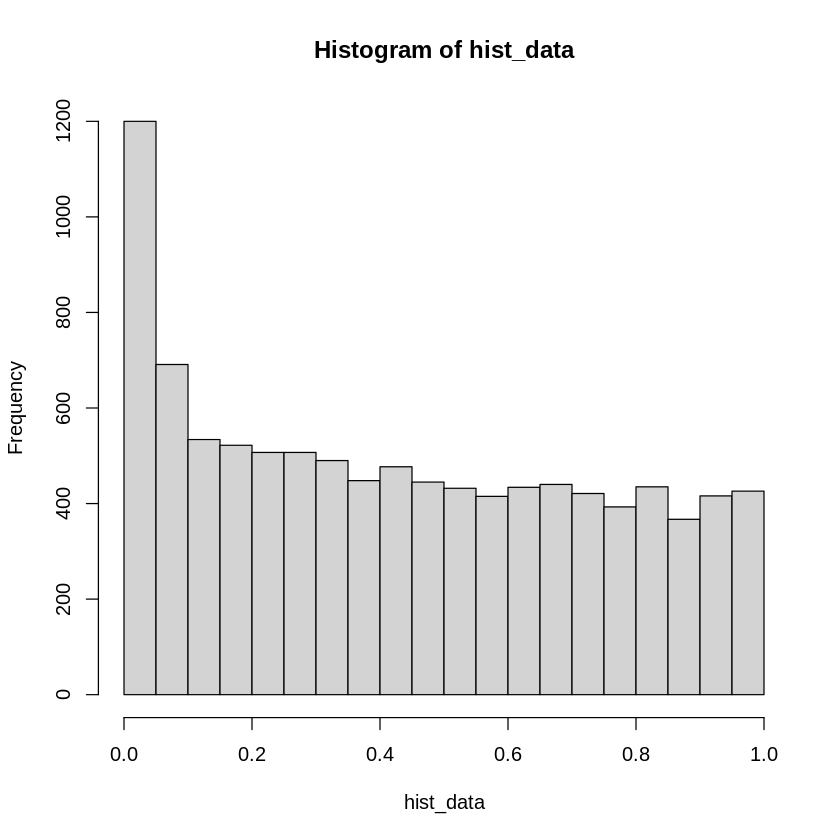

In [395]:
pvalue <- ttest[13]
hist_data <- data.matrix(pvalue)
hist(hist_data)

**Adjusted p-values using Benjamini Hochberg**

In [396]:
adj_pvalue <- p.adjust(data.matrix(pvalue), "BH")
adj_pvalue_df <-  data.frame(adj_pvalue)

## **Limma t-test**

In [397]:
limma_gene_exp <- c(group1_data, group2_data)
limma_gene_exp <- data.frame(limma_gene_exp)

**Create expression list**

create a factor list for the differentially expressed genes with group1 set as first level

In [398]:
expr_list_10k <- factor(
  x = c(rep("group1",4), rep("group2",4)),
  levels=c("group1","group2")            # Set group 1 to be the first level
)

design <- model.matrix(~expr_list_10k)          # Remove the zero
# head(design)

In [399]:
# #Now we can run the differential expression pipeline

fit <- lmFit(limma_gene_exp, design)
fit <- eBayes(fit)
results <- decideTests(fit)
# write.csv(summary(results), "summary_10k_genes_expr_sim5.csv")

In [400]:
limma_pvalue <- fit$p.value[, 2]
limma_pvalue <- data.frame(limma_pvalue)


In [401]:
adj_limma_pvalue <- data.matrix(limma_pvalue)
adj_limma_pvalue <- p.adjust(adj_limma_pvalue, "BH")
adj_limma_pvalue <- data.frame(adj_limma_pvalue)

## **Proposed Method**

In [402]:
pval_raw <- c(pvalue, limma_pvalue)
pval_raw <- data.frame(pval_raw)
pvals1 <- (as.matrix(pval_raw[,1]))
pvals2 <- (as.matrix(pval_raw[,2]))

**Calculate cut-off points using Histogram-based method**

calc.cutoff slightly modifies the estimate.m0 function to return the appropriate p-value cutoff where all p-values greater than the cutoff are assumed to come from null cases.

In [403]:
calc.cutoff = function(p, B = 20, max=1){

  m <- length(p)
  m0 <- m
  bin <- c(-0.1, (1:B)/B*max)
  bin.counts=rep(0,B)

  for(i in 1:B){
    bin.counts[i]=sum((p>bin[i])&(p<=bin[i+1]))
  }

  tail.means <- rev(cumsum(rev(bin.counts))/(1:B))
  temp <- bin.counts - tail.means
  index <- min((1:B)[temp <= 0])
  cutoff2 <- (index)/B*max
  if(cutoff2 == 1) {cutoff2 <- 1-1/B}

  return(cutoff2)

}

cutoff_value1 = calc.cutoff(pvals1, B=20, max=1)
cutoff_value2 = calc.cutoff(pvals2, B=20, max=1)

cutoff = cbind(c(cutoff_value1), c(cutoff_value2))

colnames(cutoff) = c("cutoff_value1", "cutoff_value2")

cutoff

cutoff_value1,cutoff_value2
0.6,0.5


**Filter dataset using cutoff points**

selecting pvalues in the upper-right quadrant using Histogram-Based method
defined as lambda1 = cutoffvalue1 and lambda2 = cutoffvalue2 for pvalue 1 and pvalue 2 respectively.
lambda1, lambda2 - probability of pvalue 1 and pvalue 2 in the upper-right quadrant respectively

In [404]:
p_vals = pval_raw  %>% filter(pvalue >=cutoff_value1, limma_pvalue>=cutoff_value2)

convert selected pvalues to z values

In [405]:
z_val = as.data.frame(qnorm(as.matrix(p_vals), lower.tail = TRUE))
colnames(z_val) = c("zvals1", "zvals2")

zvals1 <- (as.data.frame(as.matrix(z_val[,1])))
zvals2 <- (as.data.frame(as.matrix(z_val[,2])))

convert lambda(truncation points) to z values

In [406]:
z_val_extremums = as.data.frame(qnorm(as.matrix(cbind(c(cutoff_value1,1),c(cutoff_value2,1))), lower.tail = TRUE))

min_z1 <- z_val_extremums[1,1]
min_z2 <- z_val_extremums[1,2]

**Estimating m00s**

m0.1 - DE genes in experiment 1
m0.2 - DE genes in experiment 2
m11 - DE genes in both experiments
m00 - EE genes in both experiments

In [407]:
estimate.m0s <- function(p1, p2, B=20){
  m <- length(p1)

  ##find lambda cutoffs using histogram-based method
  c1 <- calc.cutoff(p1, B=B, max=1)
  c2 <- calc.cutoff(p2, B=B, max=1)

  ##estimate m0 for experiment 1
  ind1 <- (p1>=c1)
  m0.1 <- sum(ind1)/(1-c1)
  m0.1 <- min(m0.1, 10000)

  ##estimate m0 for experiment 2  
  ind2 <- (p2>=c2)
  m0.2 <- sum(ind2)/(1-c2)
  m0.2 <- min(m0.2, 10000)


  ##estimate m00
  ind12 <- ind1 & ind2
  nA <- sum(ind12)
  #pA <- (1-c1)*(1-c2)
  #m00 <- nA/pA
  
  #here, we used converted pvalues to z values to estimnate m00
  # density function for each row of the bivariate z values (x) and 
  # estimated parameters(rho)
  density = function(x, rho)
  {
    sigma = matrix(c(1, rho, rho, 1), 2, 2)
    z = dtmvnorm(x, mean = c(0,0), sigma = sigma, lower = c(min_z1, min_z2))
  }
  
  # log likelihood of the joint densities
  log_likelihood_fn = function(rho){
    
    joint_likelihood = z_val %>% split(.$zvals2) %>% map_dfr(~density(c(.$zvals1,.$zvals2),rho))    
    return(-sum(log(joint_likelihood)))
    
  }
  
  #MLE of the log likelihood function
  optimal_rho = optimize(log_likelihood_fn, lower = -1, upper = 1 )
  optimal_rho = as.data.frame(optimal_rho)
  
  #probability of a random variable greater than cutoff values 
  rho = as.numeric(optimal_rho[1])
  obj_value = optimal_rho[2]
  pA = pmvnorm(lower=c(min_z1, min_z2), upper=c(Inf, Inf), mean=c(0,0), sigma = matrix(c(1, rho, rho, 1), 2, 2))
  

  m00 <- nA/pA
  m00 <- min(m00, 10000)
  
  
  ##estimate m11
  m11 <- sum(m - m0.1 - m0.2 + m00)
  if (m0.1 == 10000 || m0.2 == 10000 || m00 == 10000){
    m11 = 0
  }
  
  ret <- list()
  ret$ms <- c(rho, obj_value, m, m0.1, m0.2, m11, m00)
  names(ret$ms) <- c("optimal_rho", "obj_value", "m", "m0.1", "m0.2", "m11","m00")
  ret$cutoffs <- c(c1, c2)
  return(ret)
}

estimate.m0s(pvals1, pvals2, B=20)

$ms
$ms$optimal_rho
[1] 0.9933571

$ms$obj_value
[1] -357.109

$ms$m
[1] 10000

$ms$m0.1
[1] 8330

$ms$m0.2
[1] 8388

$ms$m11
[1] 1616.678

$ms$m00
[1] 8334.678


$cutoffs
[1] 0.6 0.5

# **Orr, 2012 Method**

In [408]:
estimate.m0s <- function(p1, p2, B=20){
  m <- length(p1)

  ##find lambda cutoffs using histogram-based method
  c1 <- calc.cutoff(p1, B=B, max=1)
  c2 <- calc.cutoff(p2, B=B, max=1)

  ##estimate m0 for experiment 1
  ind1 <- (p1>=c1)
  m0.1 <- sum(ind1)/(1-c1)
  m0.1 <- min(m0.1, 10000)
  

  ##estimate m0 for experiment 2  
  ind2 <- (p2>=c2)
  m0.2 <- sum(ind2)/(1-c2)
  m0.2 <- min(m0.2, 10000)

  ##estimate m00
  ind12 <- ind1 & ind2
  nA <- sum(ind12)
  pA <- (1-c1)*(1-c2)
  m00 <- nA/pA
  m00 <- min(m00, 10000)


  ##estimate m11
  m11 <- sum(m - m0.1 - m0.2 + m00)
  if (m00 == 10000 || m0.1 == 10000 || m0.2 == 10000){
    m11 = 0
  }
  
  ret <- list()
  ret$ms <- c(m, m0.1, m0.2, m11, m00)
  names(ret$ms) <- c("m", "m0.1", "m0.2", "m11","m00")
  ret$cutoffs <- c(c1, c2)
  return(ret)
}

estimate.m0s(pvals1, pvals2, B=20)

$ms
    m  m0.1  m0.2   m11   m00 
10000  8330  8388     0 10000 

$cutoffs
[1] 0.6 0.5

# **Intersection Method**

In [409]:
adj_pvalue_df <- data.frame(adj_pvalue)
# head(adj_pvalue_df)

In [410]:
pvalue_p <- adj_pvalue_df[rowSums(adj_pvalue_df[1]<=0.05), ]
pvalue_05 <- length(pvalue_p)
#pvalue_05

In [411]:
limma_p <- adj_limma_pvalue[rowSums(adj_limma_pvalue[1]<=0.05), ]
limma_05 <- length(limma_p) 
#limma_05

In [412]:
limma_ttest <- c(adj_pvalue_df, adj_limma_pvalue)
limma_ttest <- data.frame(limma_ttest)


In [413]:
limma_ttest_p <- limma_ttest[rowSums((limma_ttest[1]<=0.05) & (limma_ttest[2]<=0.05)), ]
limma_ttest_05 <- nrow(limma_ttest_p)
limma_ttest_05

[1] 22

In [414]:
pvalue_p2 <- adj_pvalue_df[rowSums(adj_pvalue_df[1]<=0.1), ]
pvalue_1 <- length(pvalue_p2)
#pvalue_1

In [415]:
limma_p2 <- adj_limma_pvalue[rowSums(adj_limma_pvalue[1]<=0.1), ]
limma_1 <- length(limma_p2) 
#limma_1

In [416]:
# write.csv(limma_ttest, "adj_pvalue_limma.csv", row.names=FALSE)

In [417]:
limma_ttest_p2 <- limma_ttest[rowSums((limma_ttest[1]<=0.1) & (limma_ttest[2]<=0.1)), ]
limma_ttest_1 <- nrow(limma_ttest_p2)
limma_ttest_1

[1] 112

# **Venn diagram Analysis**

Controlling at alpha<=0.05 using Benjamini-Hochberg

(polygon[GRID.polygon.98], polygon[GRID.polygon.99], polygon[GRID.polygon.100], polygon[GRID.polygon.101], text[GRID.text.102], text[GRID.text.103], text[GRID.text.104], text[GRID.text.105], text[GRID.text.106]) 

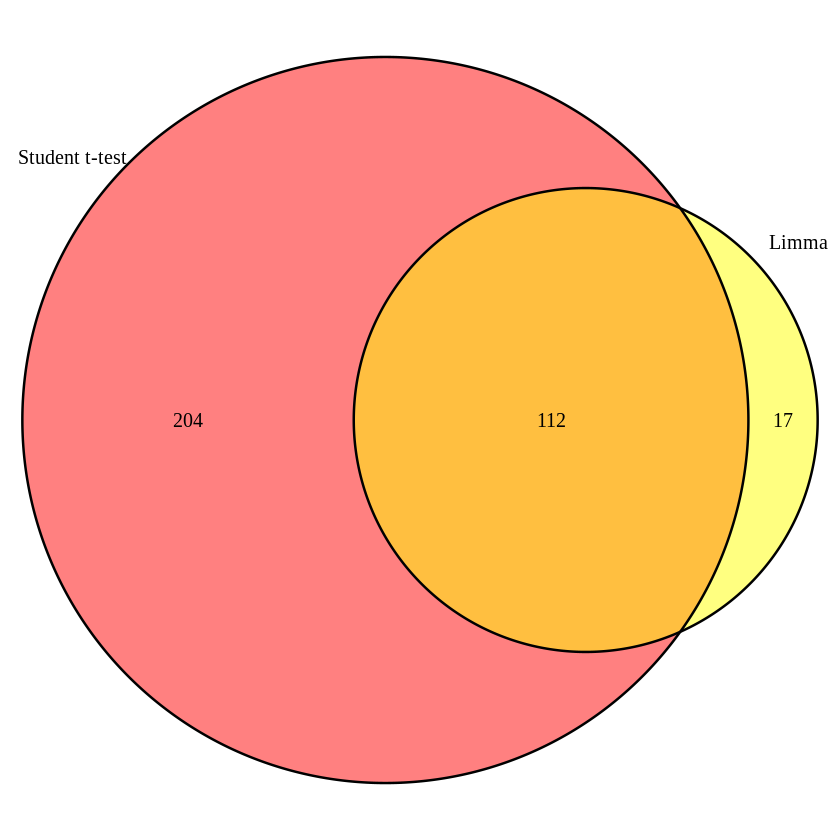

In [418]:
draw.pairwise.venn(area1=limma_1, area2=pvalue_1,cross.area=limma_ttest_1,
                   category=c("Student t-test","Limma"),fill=c("Red","Yellow"),
)